In [1]:
from graph.graph import graph
import matplotlib.pyplot as plt
import networkx as nx

mpl_params = {

    'figure.figsize': (25, 13),
}
plt.rcParams.update(mpl_params)
G = graph.graph

# Палитра цветов
## Соответствует типам беспилотников: по возрастанию размера - слева направо
## Палитра узлов

In [2]:
import seaborn

node_palette = seaborn.color_palette('muted', 3)
node_palette

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803)]

## Палитра дуг

In [3]:
edge_palette = seaborn.color_palette('pastel', 3)
edge_palette

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078)]

In [4]:
nodes = G.nodes()
pos = nx.get_node_attributes(G, 'pos')
nodes_types = nx.get_node_attributes(G, 'type')
edges_types = nx.get_edge_attributes(G, 'type')

# Исходный граф
## Тип ребер и вершин соответствует типу обслуживаемых беспилотников

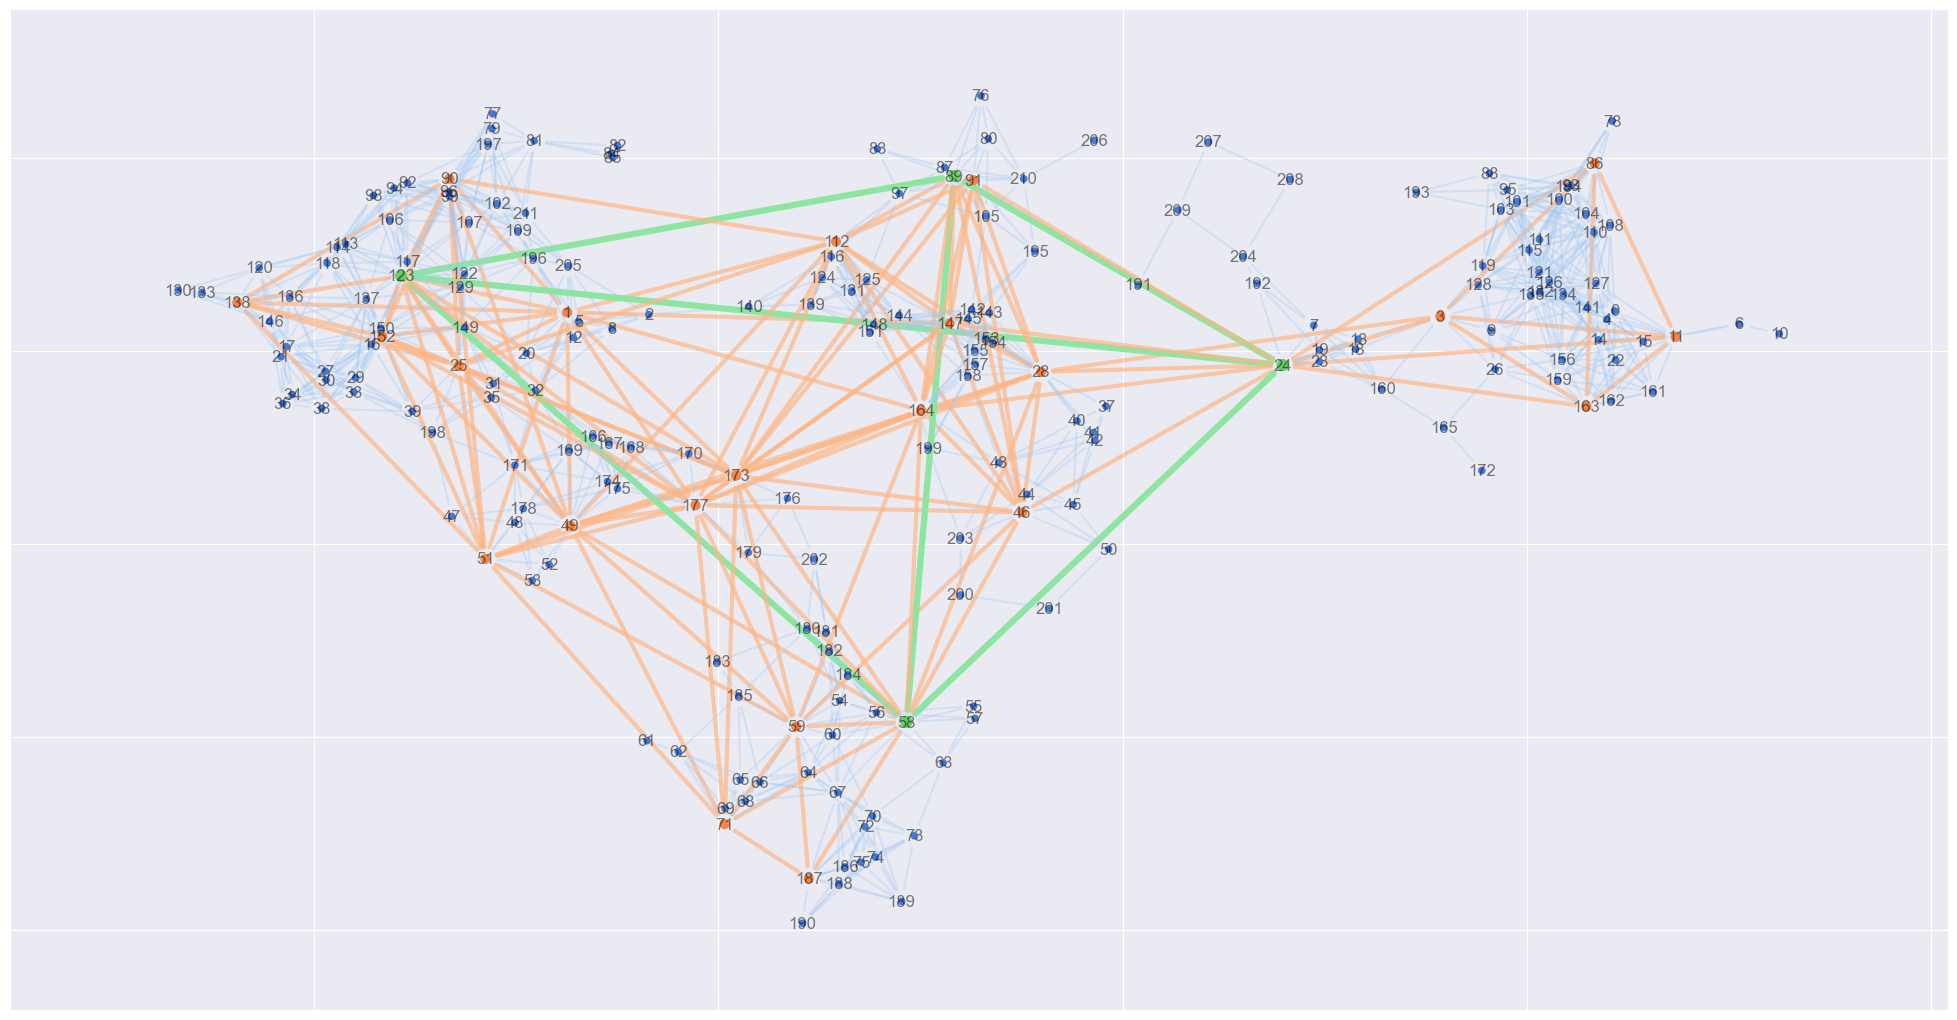

In [55]:
from typing import List

def draw_graph(what: List[str] = None, arrowstyle='-'):
    if what is None or 'edges' in what:
        nx.draw_networkx_edges(G, pos=pos,
                               edge_color=list(map(lambda x: edge_palette[x], edges_types.values())),
                               width=list(map(lambda x: (x + 1) * 1.5, edges_types.values())),
                               alpha=list(map(lambda x: (x + 1) / 3, edges_types.values())),
                               arrows=True,
                               arrowstyle=arrowstyle)
    if what is None or 'nodes' in what:
        nx.draw_networkx_nodes(G, pos=pos,
                               node_color=list(map(lambda x: node_palette[x], nodes_types.values())),
                               node_size=list(map(lambda x: (x + 1) * 20, nodes_types.values())))
    if what is None or 'labels' in what:
        nx.draw_networkx_labels(G, pos=pos,
                                alpha=0.5)


draw_graph()

# Функция стоимости перевозки N грузов на ребрах разных типов
## При фиксированном расстоянии

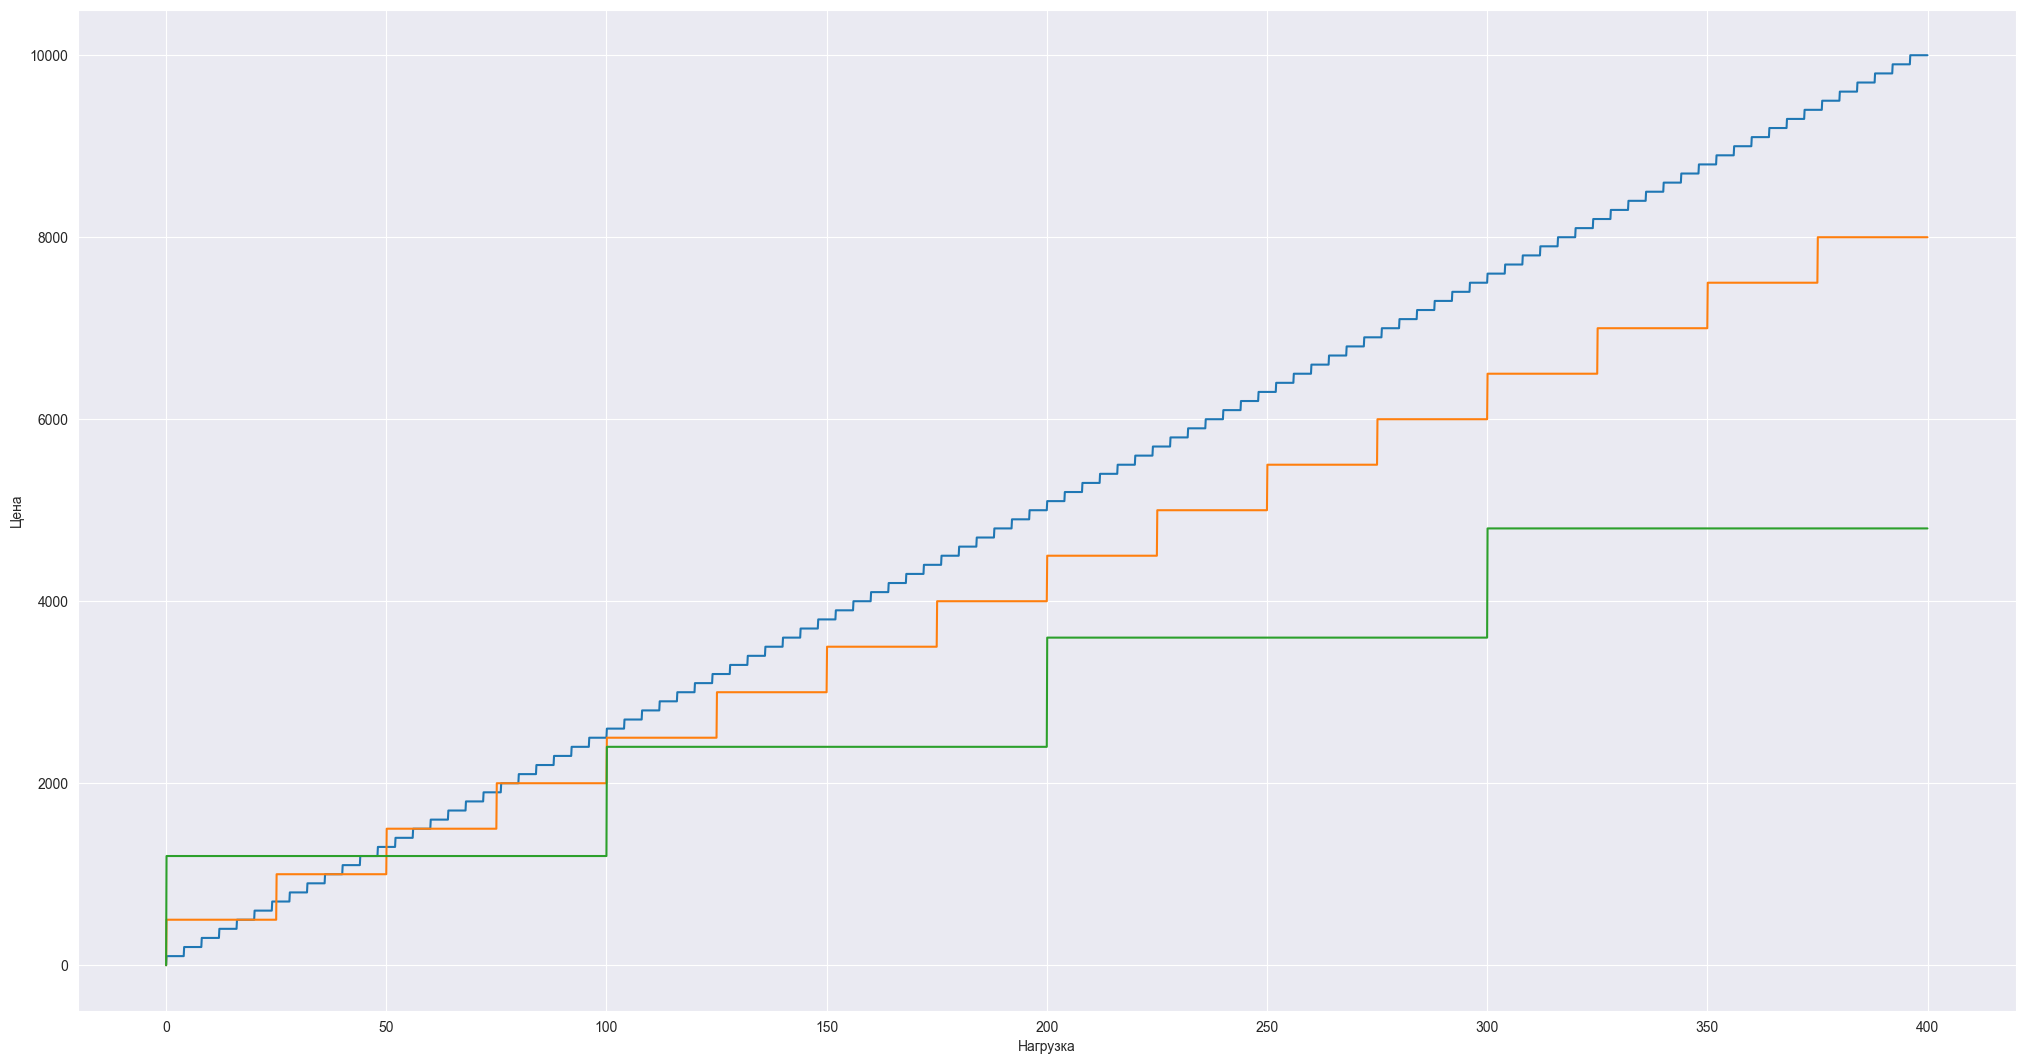

In [7]:
import numpy as np


def draw_price_function(edge_type, dist, max_payload):
    payload = np.arange(-0.01, max_payload, 0.1)
    price = np.array(graph.calc_price(edge_type, dist, payload))
    #
    plt.xlabel('Нагрузка')
    plt.ylabel('Цена')

    plt.plot(payload, price)


draw_price_function(0, 100, 400)
draw_price_function(1, 100, 400)
draw_price_function(2, 100, 400)

#  K кратчайших путей
## Для примера - между вершинами 10 и 130
## Красным отмечен кратчайший путь

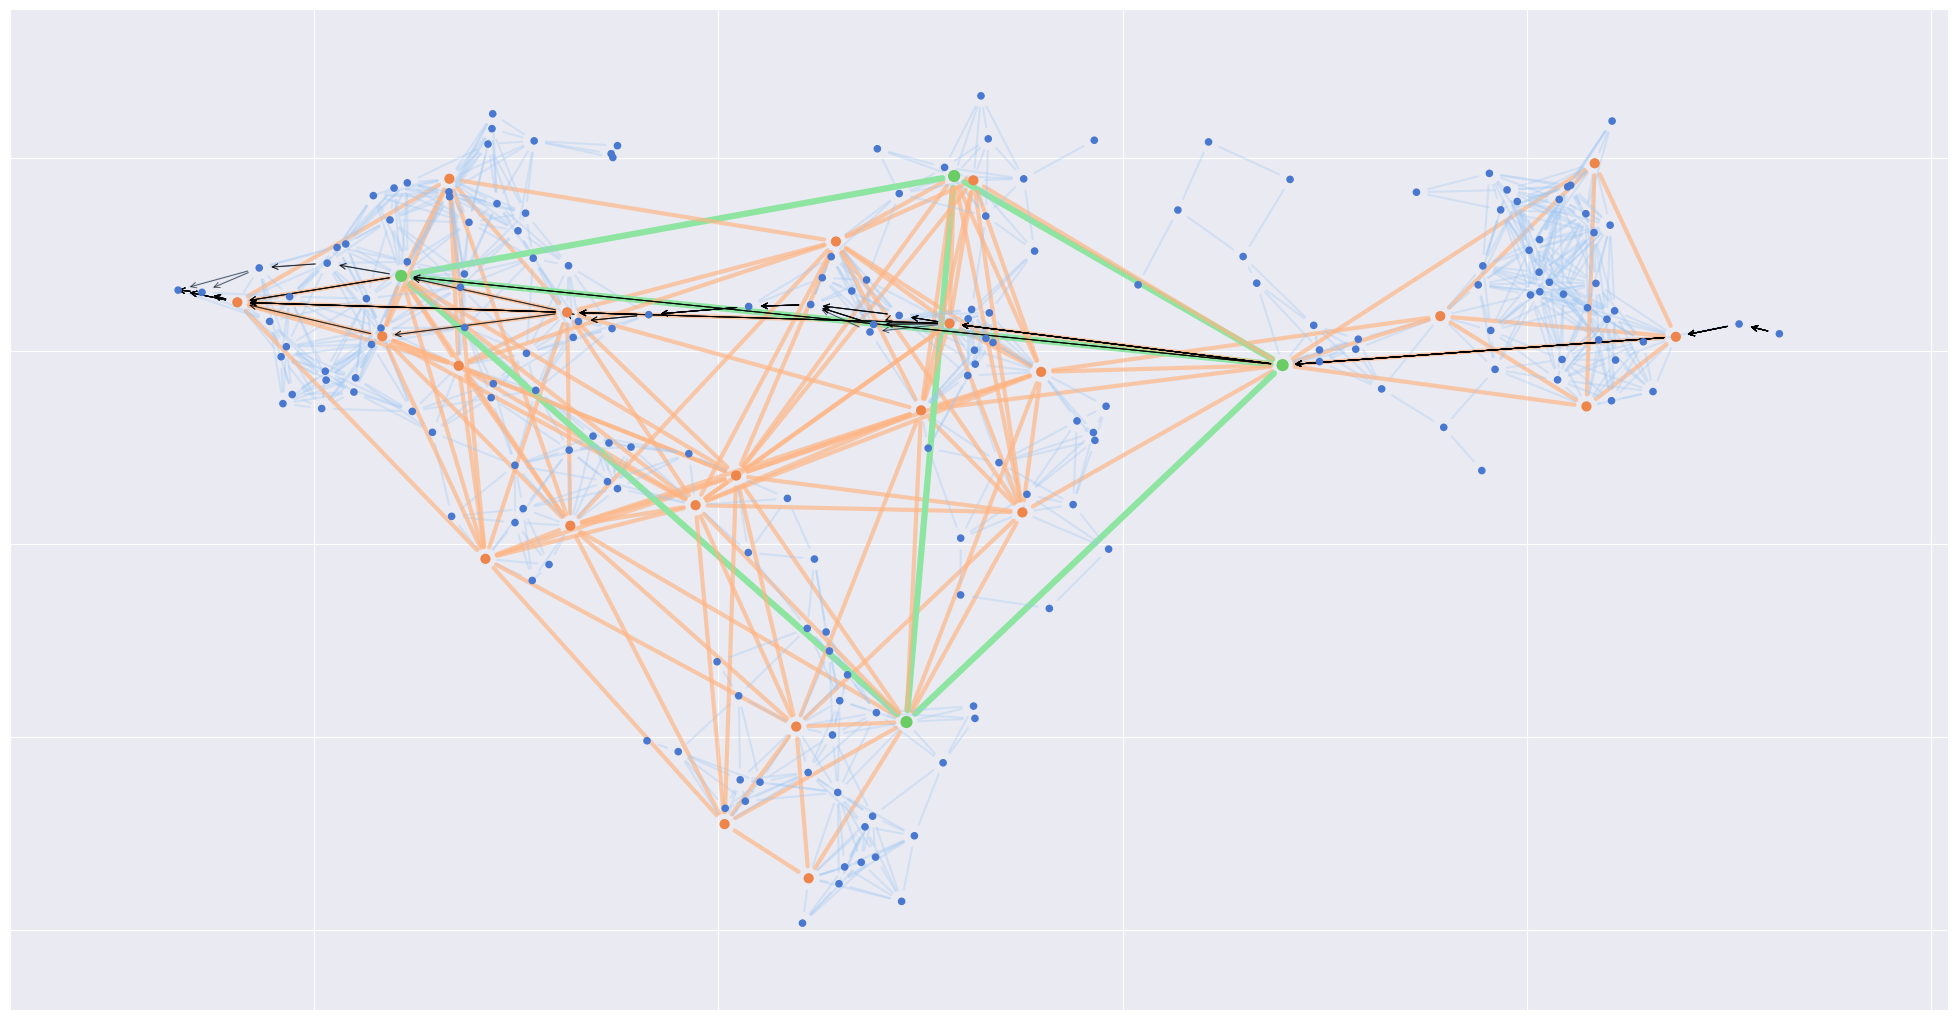

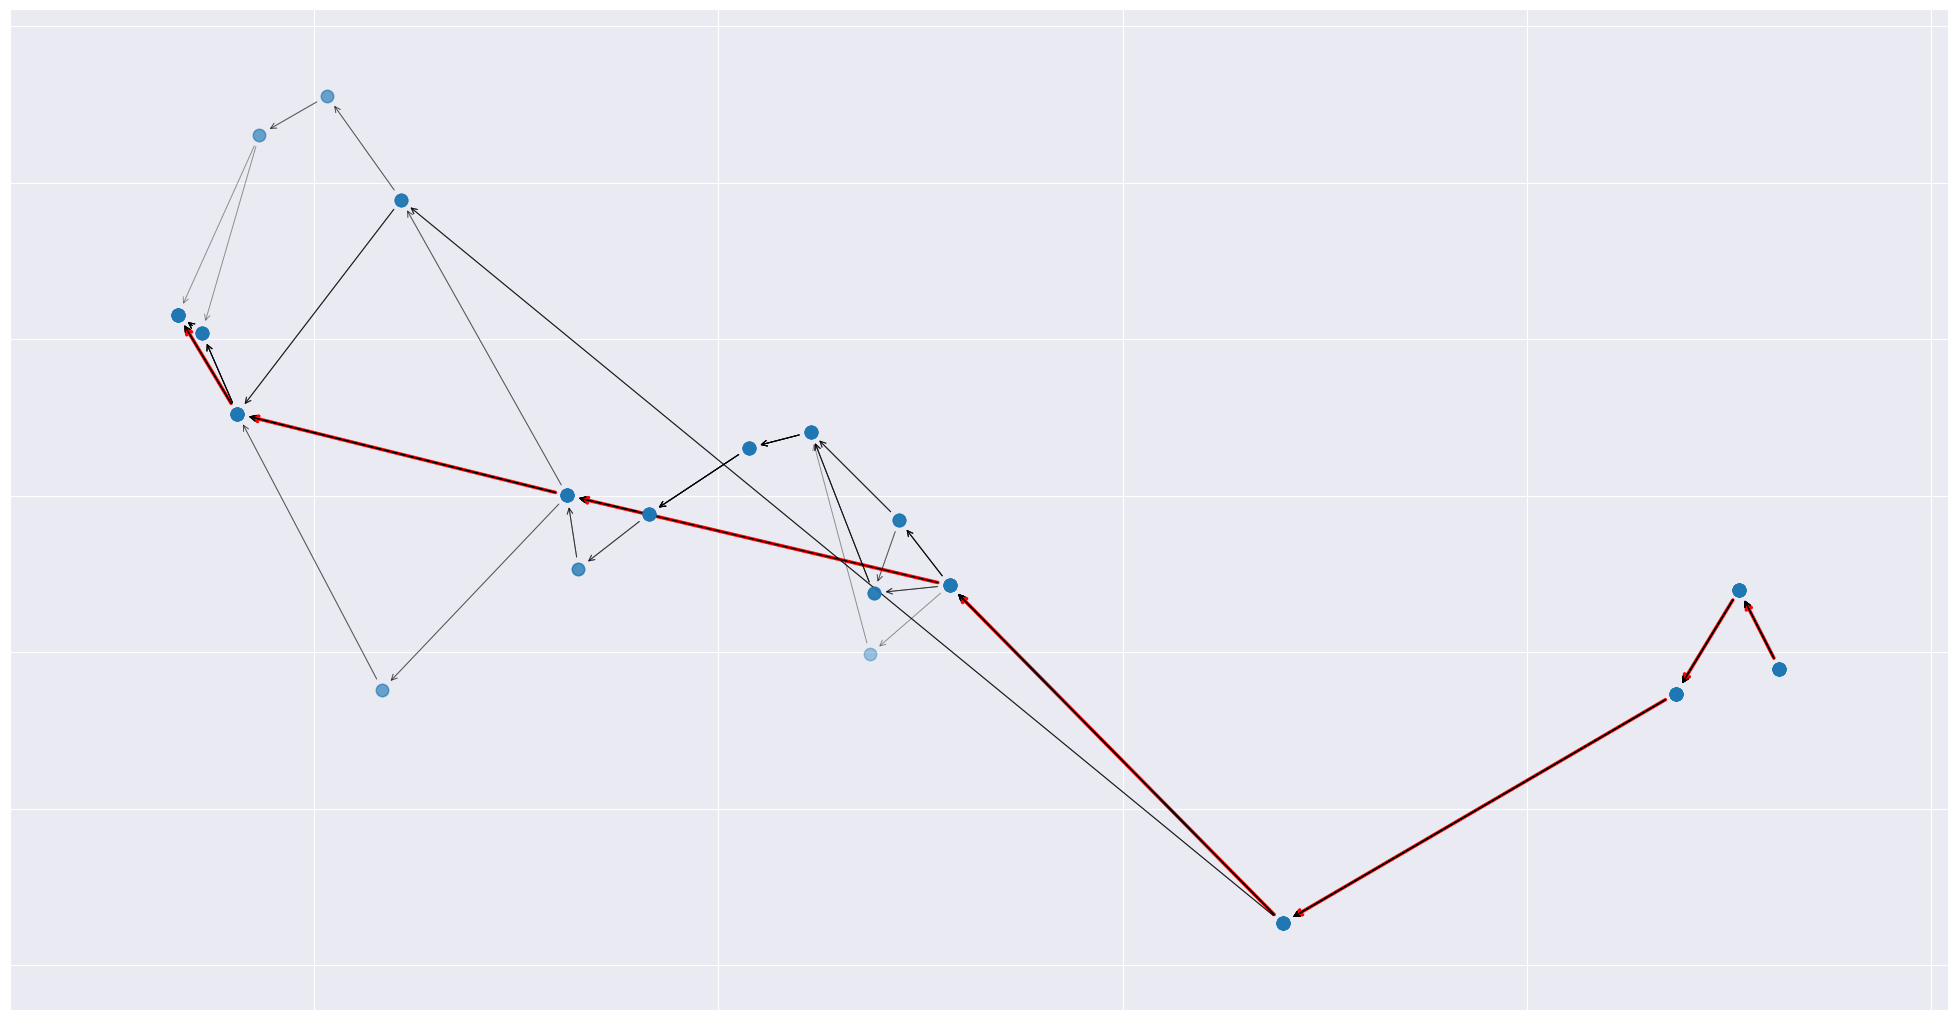

In [64]:
from logistics.k_shortest import k_shortest



paths = k_shortest(G, 10, 130, 'dist')
def edges_from_path(p):
    result = []
    for i in range(len(p) - 1):
        result.append((p[i], p[i + 1]))
    return result
plt.figure(1)
draw_graph(['nodes', 'edges'])
for path in paths:
    nx.draw_networkx_edges(G, pos=pos, edgelist=edges_from_path(path), alpha=0.6, arrows=True, arrowstyle='->', width=0.7)
plt.figure(2)
for i, path in enumerate(paths):
    nx.draw_networkx_edges(G, pos=pos, edgelist=edges_from_path(path), alpha=1 if i == 0 else 0.4,
                           arrows=True, arrowstyle='->', width=2.5 if i == 0 else 0.7, edge_color='red' if i == 0 else 'k')
    nx.draw_networkx_nodes(G, pos=pos, nodelist=path, alpha=0.4, node_size=80)
    # nx.draw_networkx_labels(G, pos=pos, labels=dict(zip(path, path)), horizontalalignment='left')